# Ice Fitting package (Using ML and MCMC algorithms)


The code below is an ice-fitting package which fits the observed spectra using both Machine learning(ML) and Markov Chain Monte Carlo(MCMC) algorithms.  
  
### Machine Learning
For the machine learning model we use a Non-Negative Least square model. This ensure that the weights of the lab ices does not become negative.  

### Markov Chain Monte Carlo  
For the MCMC algorithm we use Metroplois-Hastings algorithm. 

### Important Library Functions used

In [1]:
from IPython.display import clear_output
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d # Scipy module for interpolation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

### Module to read .dat spectrum files from the laboratory ice folder

In [2]:
# Function to read spectral data from a file
def read_spectrum_folder(folder_path):
    def read_spectrum_file(file_path):
        with open(file_path, 'r') as file:
        # Initialize empty lists for x and y data
            x = []
            y = []
            
            # Iterate over each line in the file
            for line in file:
                # Split the line into tokens (assuming space-separated values)
                tokens = line.split()
                
                # Convert tokens to floats and append to x and y arrays
                x.append(float(tokens[0]))
                y.append(float(tokens[1]))
        spectrum_data = (x,y)
        return spectrum_data

    # Initialize an empty dictionary to store spectral data
    spectral_data_dict = {}

    # Iterate over each file in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path) and filename.endswith('.dat'):
            spectral_data_dict[filename[:-4]] = read_spectrum_file(file_path)
    
    return spectral_data_dict

c=0
# Path to the folder containing the spectrum data files
folder_path = 'D:\\ENIIGMA-fitting-tool-master\\ENIIGMA\\ICE_LIB'  # Folder path
spectrum_dict = {}
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    print(file_path)
    spectral_data_dict ={}
    if os.path.isdir(file_path):
        spectral_data_dict = read_spectrum_folder(file_path)
    spectrum_dict.update(spectral_data_dict)
    if os.path.isfile(file_path) and filename.endswith('.dat') and c==0:
        c=1
        spectral_data_dict = read_spectrum_folder(folder_path)
    spectrum_dict.update(spectral_data_dict)

D:\ENIIGMA-fitting-tool-master\ENIIGMA\ICE_LIB\.DS_Store
D:\ENIIGMA-fitting-tool-master\ENIIGMA\ICE_LIB\MI_ICES


D:\ENIIGMA-fitting-tool-master\ENIIGMA\ICE_LIB\MT_ICES
D:\ENIIGMA-fitting-tool-master\ENIIGMA\ICE_LIB\PT_ICES
D:\ENIIGMA-fitting-tool-master\ENIIGMA\ICE_LIB\P_ICES
D:\ENIIGMA-fitting-tool-master\ENIIGMA\ICE_LIB\Silicate
D:\ENIIGMA-fitting-tool-master\ENIIGMA\ICE_LIB\__init__.py
D:\ENIIGMA-fitting-tool-master\ENIIGMA\ICE_LIB\__pycache__


### Code snippet to convert wavenumber(cm^-1) to wavelength(micron) datapoints

In [3]:
for filename, data in spectrum_dict.items():
    wavenumber,absorbance = data
    wavelength = [10000/w for w in wavenumber]
    spectrum_dict[filename] = wavelength,absorbance

### Module to inerpolate the absorbance values at the required range[a,b] and resolution(r)

In [4]:
# Function to interpolate absorbance values at wavelength values other than datapoints
def interpolation(wavelength,absorbance,min_wavelength, max_wavelength,r):
    # Perform linear interpolation
    interpolated_wavelength = np.linspace(max(math.ceil(wavelength[0]),min_wavelength), min(math.floor(wavelength[-1]),max_wavelength), num=int((min(math.floor(wavelength[-1]),max_wavelength)-max(math.ceil(wavelength[0]),min_wavelength))/r + 1))  # New wavelength range
    interpolator = interp1d(wavelength, absorbance, kind='cubic')  # Cubic interpolation
    interpolated_absorbance = interpolator(interpolated_wavelength)  # Interpolated absorbance values
    return interpolated_wavelength,interpolated_absorbance

# Function to combine the constituent specttras to form synthetic spectra
def interpolator(spectra, min_wavelength, max_wavelength,r):
    
    # Create a common set of wavenumbers for interpolation
    common_wavelengths = np.linspace(min_wavelength, max_wavelength, int((max_wavelength-min_wavelength)/r + 1))
    
    # Initialize arrays to store the combined absorbance
    combined_absorbance = np.zeros_like(common_wavelengths)
    
    wavelength, absorbance = spectra
    
    if (wavelength[-1]<=min_wavelength) or (wavelength[0]>=max_wavelength) or (min_wavelength>=max_wavelength):
        absorbance = np.zeros((int((max_wavelength-min_wavelength)/r + 1)))
        wavelength = common_wavelengths
    else:
        wavelength, absorbance = interpolation(wavelength, absorbance,min_wavelength, max_wavelength,r)

    # Extend the range of spectrum if missing regions
    if wavelength[0]>min_wavelength:
        absorbance = np.concatenate((np.zeros(math.floor((wavelength[0]-min_wavelength)/r)), absorbance))
    if wavelength[-1]<max_wavelength:
        absorbance = np.concatenate((absorbance, np.zeros(math.floor((max_wavelength-wavelength[-1])/r))))

    # Add the interpolated absorbance to the combined absorbance
    combined_absorbance = absorbance
    
    return common_wavelengths, combined_absorbance

Code to interpolate all the laboratory ices

In [5]:
a = 6.8 # Lower wavelength limit
b = 8.6 # Upper wavelength limit
r = 0.0005 # resolution of wavelength datapoints
for filename, data in spectrum_dict.items():
    wavelength,absorbance = data
    wavelength,absorbance = interpolator(data,a,b,r)
    spectrum_dict[filename] = wavelength,absorbance

Create the x and y datasets to be input into the ML algorithm

In [6]:
x=[]
for filename, data in spectrum_dict.items():
    x.append(data[1])
x = np.array(x)
x = x.transpose()

def read_data(file_path):
    # Read data from file
    data = np.loadtxt(file_path)

    # Separate x and y values
    x_values = data[:, 0]
    y_values = data[:, 1]
    z_values = data[:, 2]

    spectra = (x_values , y_values)

    return spectra

"""
Reading data from the observed spectra file
"""
path="C:\\Users\\manor\\OneDrive\\Desktop\\P452 Project\\Removed_silicate_spectrum.txt" # Path of the spectrum file
wavelength_syn,absorbance_syn = read_data(path)
wavelength_syn,absorbance_syn = interpolator((wavelength_syn,absorbance_syn),a,b,r)
y = absorbance_syn

### The Machine learning(Non-negative least square) module 

In [7]:
def nnls(A, b, max_iter=1000, tol=1e-6):
    """
    Solves the Non-negative Least Squares (NNLS) problem: minimize ||Ax - b||^2
    subject to x >= 0, where A is an m x n matrix, b is a vector of length m,
    and x is a vector of length n.

    Parameters:
    - A: numpy array of shape (m, n)
    - b: numpy array of shape (m,)
    - max_iter: maximum number of iterations (default is 1000)
    - tol: tolerance for convergence (default is 1e-6)

    Returns:
    - x: numpy array of shape (n,) representing the solution
    - residuals: numpy array of shape (m,) representing the residuals
    """

    m, n = A.shape
    x = np.zeros(n)
    active_set = np.arange(n)
    
    for _ in range(max_iter):
        # Solve least squares problem for the active set
        A_active = A[:, active_set]
        x_active = np.linalg.lstsq(A_active, b, rcond=None)[0]
        
        # Check if solution is non-negative
        if np.all(x_active >= -tol):
            x_new = np.zeros(n)
            x_new[active_set] = x_active
            return x_new, b - np.dot(A, x_new)
        
        # Find index of most negative entry in x_active
        idx = np.argmin(x_active)
        idx_in_A = active_set[idx]
        
        # Move idx_in_A from active set to inactive set
        active_set = np.delete(active_set, idx)
        
        # Calculate step size for moving along the negative direction
        d = np.zeros(n)
        d[idx_in_A] = x_active[idx]
        t = x[idx_in_A] / d[idx_in_A]
        
        # Update x and residuals
        x += t * d
        residuals = b - np.dot(A, x)
        
        # Check convergence
        if np.linalg.norm(residuals) < tol:
            break
    
    return x, residuals

### Code snippet to implement NNLS algorithm

In [8]:
def ml(x,y):

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # Fit the model using NNLS(Non-negative least square)
    coefficients, residuals = nnls(X_train, y_train)
    
    # Predict using the trained model
    y_pred = np.dot(X_test, coefficients)

    # Calculate error and correlation of each feature with target variable
    errors = np.abs(y_test - y_pred)
    correlations = np.abs(np.corrcoef(np.vstack((X_test.T, y_test)))[-1, :-1])

    # Calculate mean squared error
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)

    return mse,coefficients,errors,correlations


### Running ML algorithm and plotting the actual spectra and predicted spectra

Mean Squared Error: 0.003905168265679474


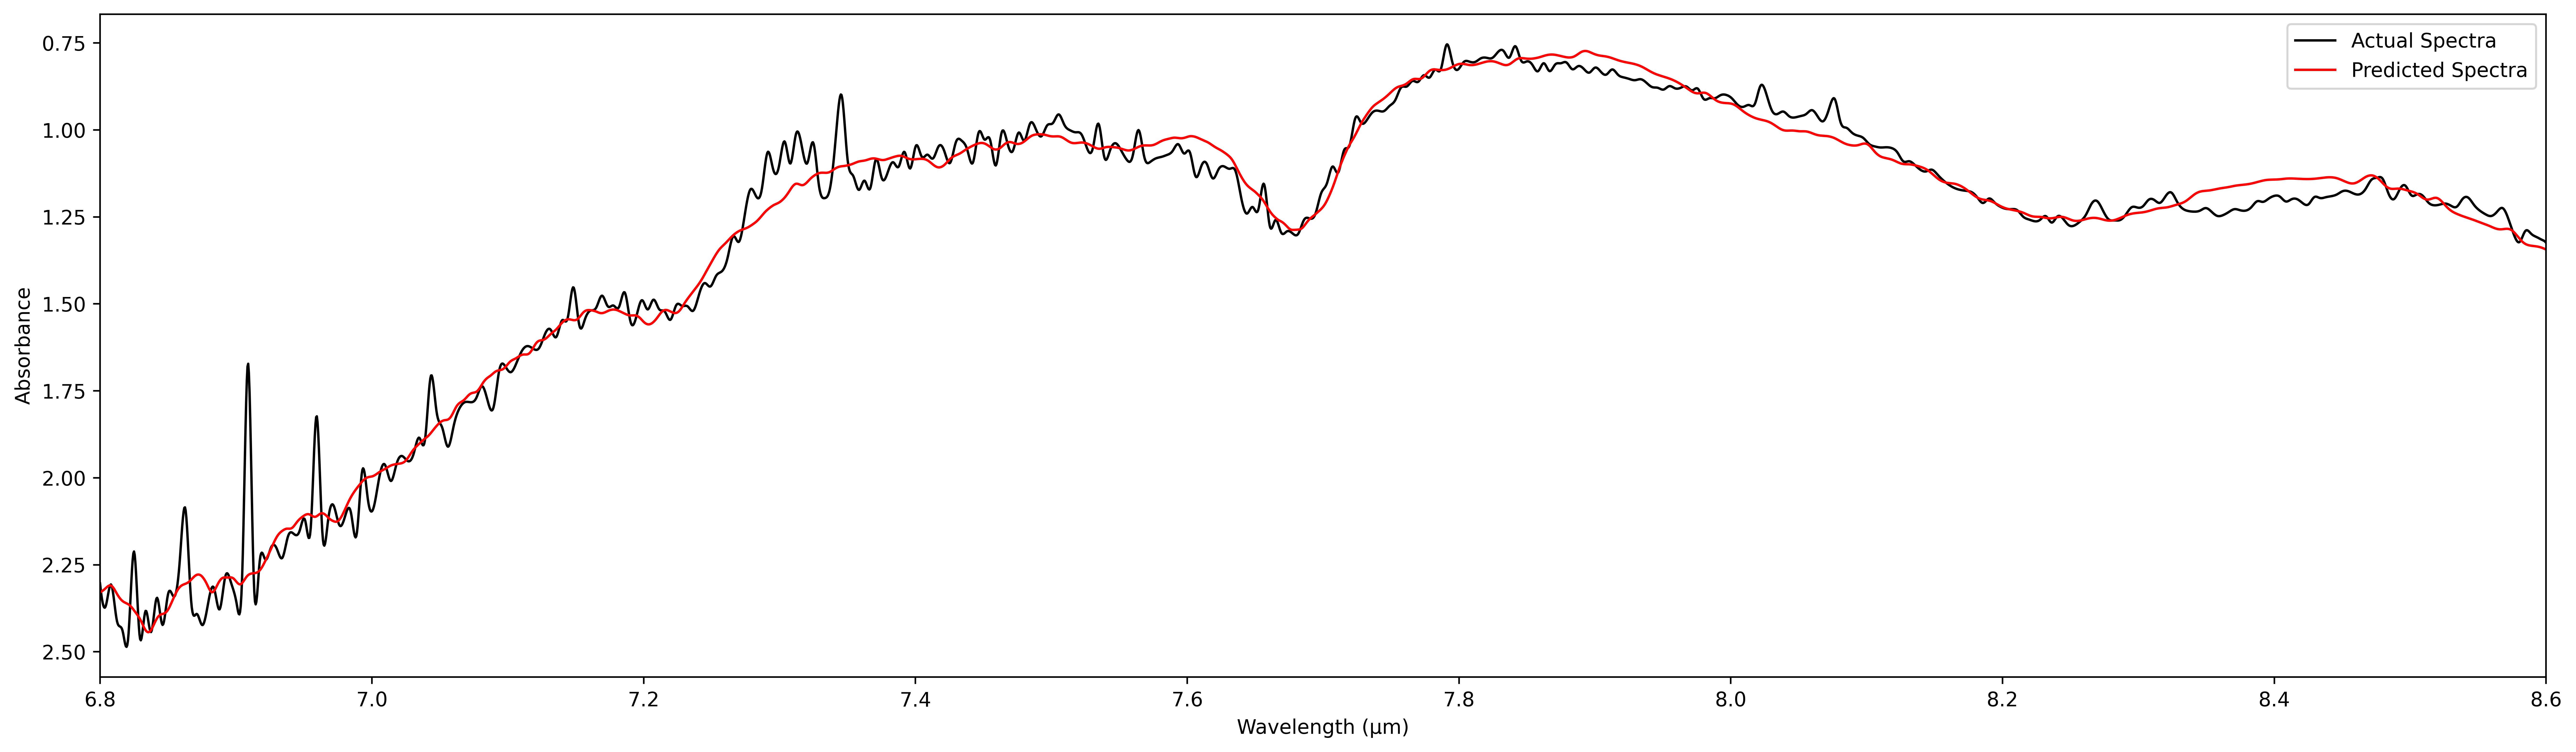

In [9]:
absorbance_pred = np.zeros((len(absorbance_syn)))
mse,coefficients,errors,correlations=ml(x,y)
for i in range(x.shape[1]):
    absorbance_pred+=(x[:,i]*coefficients[i])

plt.figure(figsize=(22,6),dpi=600)
plt.plot(wavelength_syn,y,color="black",label="Actual Spectra",linewidth=1.2)
plt.plot(wavelength_syn,absorbance_pred,color="red",label="Predicted Spectra",linewidth=1.2)
plt.xlabel("Wavelength (\u03BCm)")
plt.ylabel("Absorbance")
plt.xlim(a,b)
#plt.ylim(0,8)
plt.legend()
plt.gca().invert_yaxis()
plt.show()

### Plotting the individual ice components as predicted by ML algorithm

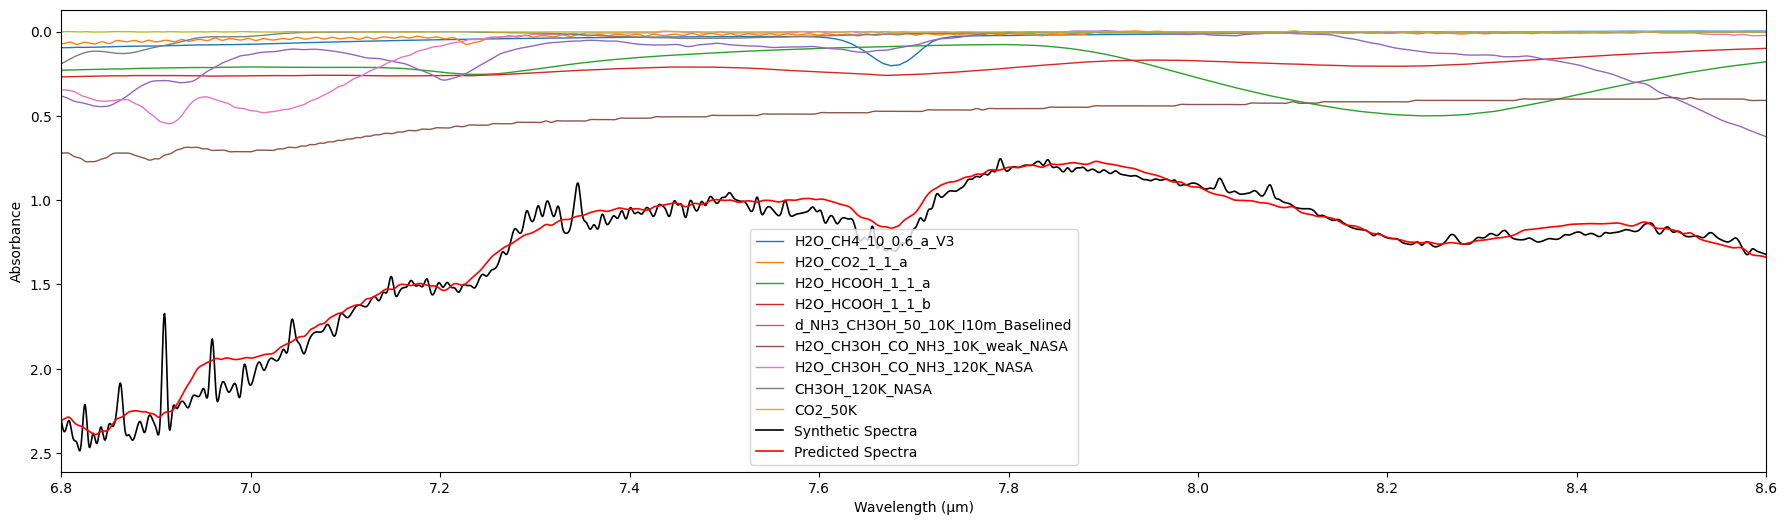

In [10]:

keys=list(spectrum_dict.keys())
plt.figure(figsize=(22,6))
absorbance_pred = np.zeros((len(absorbance_syn)))
for i in range(x.shape[1]):
    if coefficients[i]>=0.5:
        absorbance_pred+=(x[:,i]*coefficients[i])
        plt.plot(wavelength_syn,x[:,i]*coefficients[i],'-',label=keys[i],linewidth=1)

plt.plot(wavelength_syn,y,color="black",label="Synthetic Spectra",linewidth=1.2)
plt.plot(wavelength_syn,absorbance_pred,color="red",label="Predicted Spectra",linewidth=1.2)
plt.xlabel("Wavelength (\u03BCm)")
plt.ylabel("Absorbance")
plt.xlim(a,b)
plt.legend()
plt.gca().invert_yaxis()
plt.show()

### Removing some coefficients by applying limits on correlation and coefficient(i.e. filtering)

H2O_CH3OH_1_1_a : Error =  0.027369078460655283 , Correlation =  0.7335515762529615 , Coefficient =  0.0
H2O_CH3OH_1_1_b : Error =  0.03986711876748106 , Correlation =  0.6986029137131614 , Coefficient =  0.0
H2O_CH3OH_1_1_c : Error =  0.003210634743413765 , Correlation =  0.5644365865350255 , Coefficient =  0.0
H2O_CH4_10_0.6_a_V3 : Error =  0.15568618826678282 , Correlation =  0.533479021189613 , Coefficient =  6.27499432552424
H2O_CH4_10_0.6_c : Error =  0.045109523940073615 , Correlation =  0.7775089793266796 , Coefficient =  0.0
H2O_CO2_10_1_a : Error =  0.021228664992874235 , Correlation =  0.9327117616890881 , Coefficient =  0.0
H2O_CO2_10_1_b : Error =  0.08240489617960822 , Correlation =  0.7529469622943082 , Coefficient =  0.0
H2O_CO2_10_1_c : Error =  0.010853507654030148 , Correlation =  0.7779862637708237 , Coefficient =  0.0
H2O_CO2_1_1_a : Error =  0.08078453309388944 , Correlation =  0.8524733286960727 , Coefficient =  33.653130028775415
H2O_CO2_1_1_b : Error =  0.18912

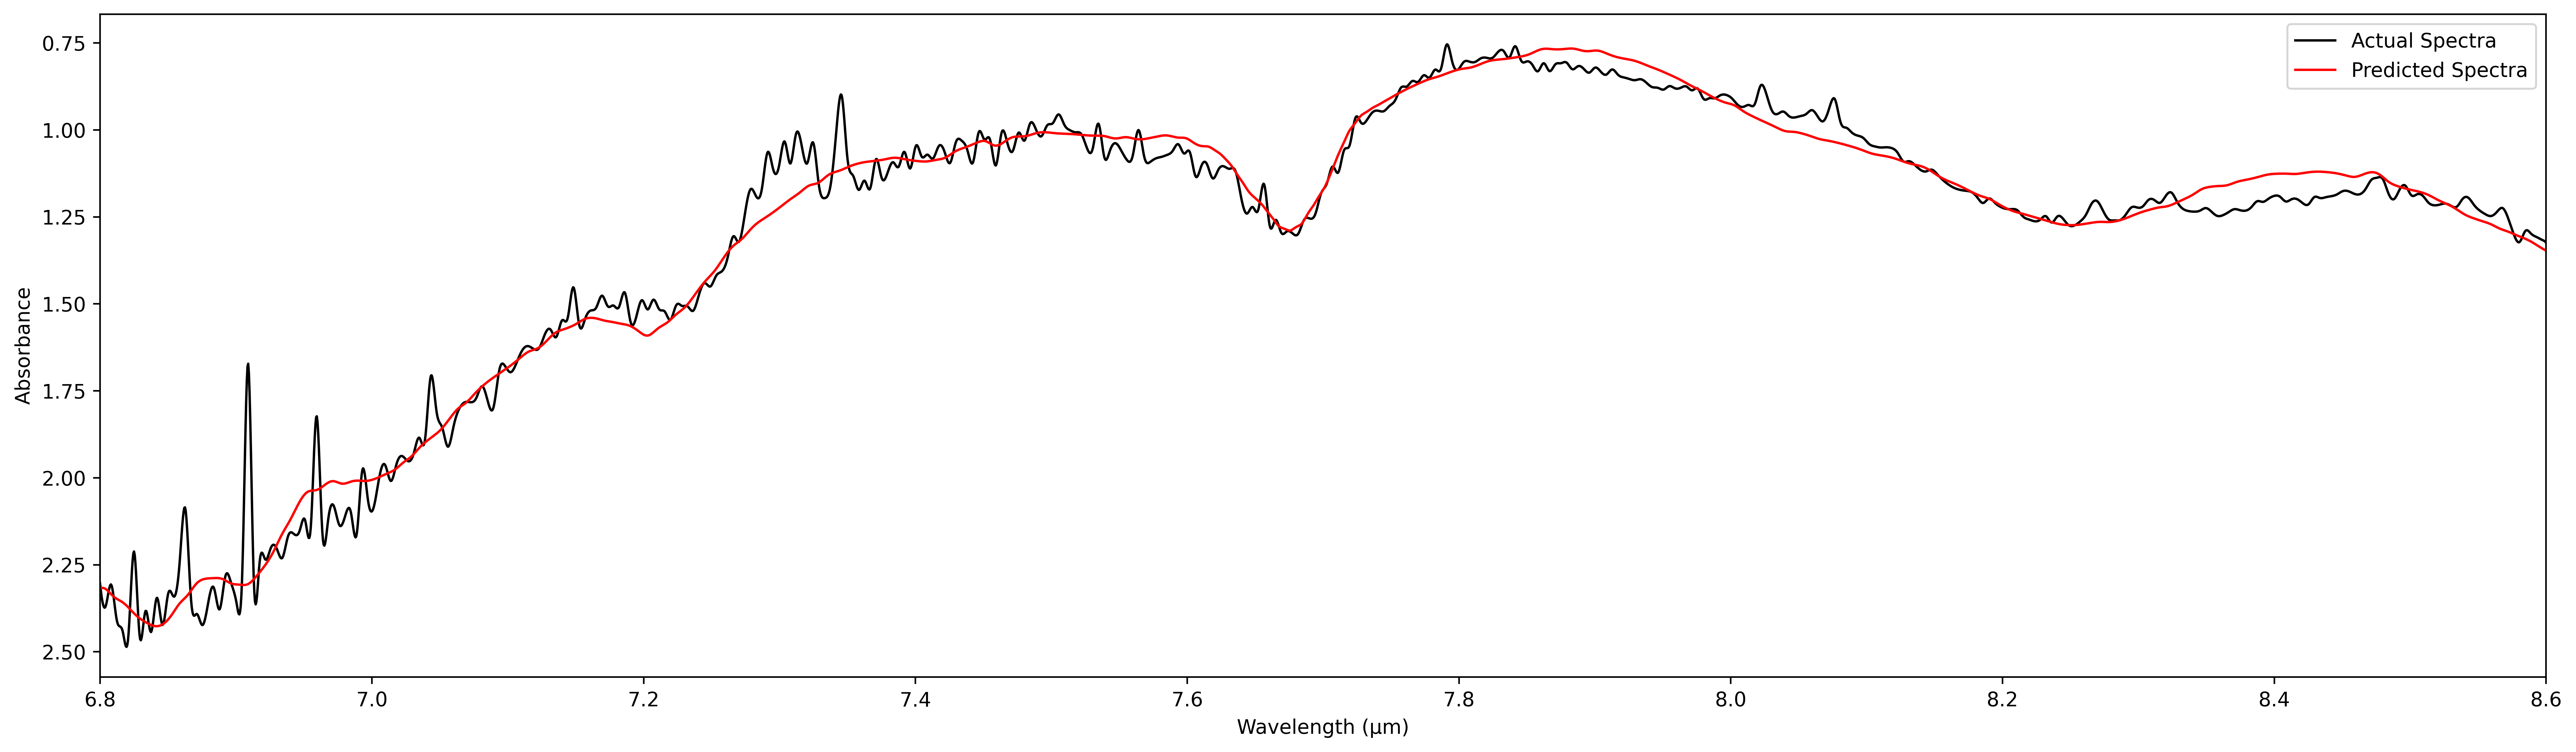

In [11]:
x_new=[]
keys_new=[]
keys=list(spectrum_dict.keys())
for i in range(len(coefficients)):
    if correlations[i]>=0.5 or coefficients[i]>0.5:
        keys_new.append(keys[i])
        x_new.append(x[:,i])
        print(keys[i],": Error = ",errors[i],", Correlation = ",correlations[i],", Coefficient = ",coefficients[i])

x_new=np.array(x_new)
x_new = x_new.transpose()
absorbance_pred_new = np.zeros((len(absorbance_syn)))
mse,coefficients_new,errors_new,correlations_new=ml(x_new,y)
for i in range(x_new.shape[1]):
    absorbance_pred_new+=(x_new[:,i]*coefficients_new[i])


plt.figure(figsize=(22,6),dpi=600)
plt.plot(wavelength_syn,y,color="black",label="Actual Spectra",linewidth=1.2)
plt.plot(wavelength_syn,absorbance_pred_new,color="red",label="Predicted Spectra",linewidth=1.2)
plt.xlabel("Wavelength (\u03BCm)")
plt.ylabel("Absorbance")
plt.xlim(a,b)
plt.legend()
plt.gca().invert_yaxis()
plt.show()

### Metropolis-Hastings alogrithm to implement MCMC

In [17]:
# Define likelihood function
def likelihood(y, y_pred):
    return np.mean((y - y_pred)**2)

# Define log posterior function
def log_posterior(coeffs, x_data, y_data):

    y_pred = np.dot(x_data, coeffs)
    
    return np.log(likelihood(y_data, y_pred)) 

# Metropolis-Hastings MCMC algorithm
def metropolis_hastings(x_data, y_data, num_samples, proposal_sd):

    num_coeffs = x_data.shape[1]
    current_coeffs = np.random.rand(num_coeffs)  # Initialize with random non-negative coefficients
    samples = [current_coeffs]

    for _ in range(num_samples):

        proposed_coeffs = current_coeffs + np.random.normal(scale=proposal_sd, size=num_coeffs)

        if np.any(proposed_coeffs < 0):
            proposed_coeffs=0.5*(abs(proposed_coeffs) + proposed_coeffs)

        log_prob_diff = log_posterior(proposed_coeffs, x_data, y_data) - log_posterior(current_coeffs, x_data, y_data)

        if log_prob_diff < 0:
            current_coeffs=np.array(proposed_coeffs)
            samples.append(proposed_coeffs)
    print("Mean squared error:",math.exp(log_posterior(proposed_coeffs, x_data, y_data)))
    return np.array(samples)

### Running MCMC module to find predicted spectra

The ML algorithm overfits the target spectra.  
  
  
To ensure that the ML does not overfit, we use MCMC algorithm to predict the spectra using only those component ices which have higher correlation or coefficient.  
  
  
If the predicted spectra fits the the actual spectra with increasing number of sampling, then we can say that ML algorithm gives correct result and does not overfit.

Mean squared error: 0.14997334625861677
No. of positive samples in MCMC sampling 19
H2O_CH3OH_1_1_a : Error =  0.03943224589969718 , Correlation =  0.7335515762529615 , Coefficient =  0.060440204565006796
H2O_CH3OH_1_1_b : Error =  0.03268194349447762 , Correlation =  0.6986029137131614 , Coefficient =  0.14820843530574151
H2O_CH3OH_1_1_c : Error =  0.011260539811656978 , Correlation =  0.5644365865350255 , Coefficient =  0.0
H2O_CH4_10_0.6_a_V3 : Error =  0.025003264287597915 , Correlation =  0.533479021189613 , Coefficient =  3.284414090217155
H2O_CH4_10_0.6_c : Error =  0.16619063447307347 , Correlation =  0.7775089793266796 , Coefficient =  0.4783835727291287
H2O_CO2_10_1_a : Error =  0.02174659302011106 , Correlation =  0.9327117616890881 , Coefficient =  0.0
H2O_CO2_10_1_b : Error =  0.009853357312029631 , Correlation =  0.7529469622943082 , Coefficient =  0.7030090214329293
H2O_CO2_10_1_c : Error =  0.028535207002420293 , Correlation =  0.7779862637708237 , Coefficient =  1.8193

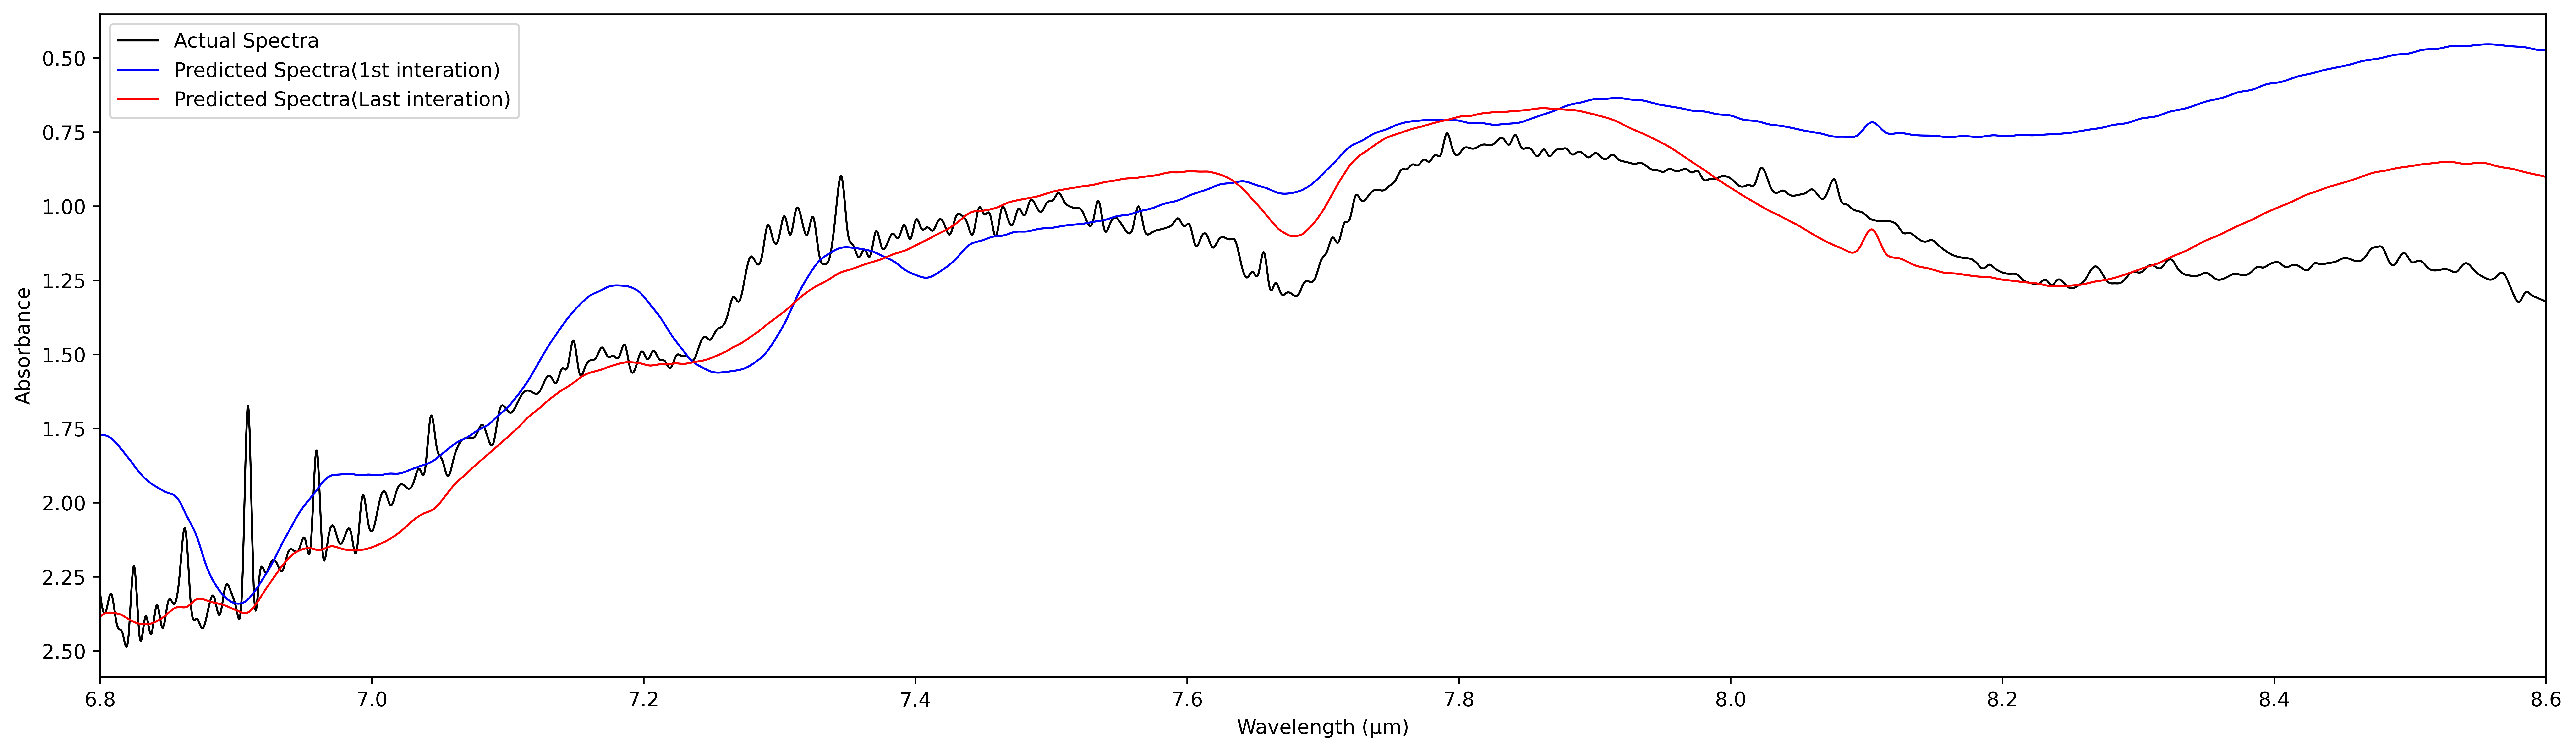

In [18]:
# Set MCMC parameters
num_samples = 10000
proposal_sd = 0.5

# Run MCMC
x_data = np.array(x_new)
y_data = np.array(y)
samples = metropolis_hastings(x_data, y_data, num_samples, proposal_sd)

print("No. of positive samples in MCMC sampling",len(samples))
# i.e. positive means sample which fits data more accurately

accepted_samples = samples[0]
accepted_samples_end = samples[-1]
absorbance_pred_mcmc = np.zeros((len(absorbance_syn)))
absorbance_pred_mcmc_end = np.zeros((len(absorbance_syn)))
for i in range(x_new.shape[1]):
    absorbance_pred_mcmc+=(x_new[:,i]*accepted_samples[i])
    absorbance_pred_mcmc_end+=(x_new[:,i]*accepted_samples_end[i])


for i in range(len(accepted_samples_end)):
    print(keys_new[i],": Error = ",errors_new[i],", Correlation = ",correlations_new[i],", Coefficient = ",accepted_samples_end[i])
plt.figure(figsize=(22,6),dpi=600)
plt.plot(wavelength_syn,y,color="black",label="Actual Spectra",linewidth=1.0)
plt.plot(wavelength_syn,absorbance_pred_mcmc,color="blue",label="Predicted Spectra(1st interation)",linewidth=1.0)
plt.plot(wavelength_syn,absorbance_pred_mcmc_end,color="red",label="Predicted Spectra(Last interation)",linewidth=1.0)
plt.xlabel("Wavelength (\u03BCm)")
plt.ylabel("Absorbance")
plt.xlim(a,b)
plt.legend()
plt.gca().invert_yaxis()
plt.show()

#### Running the ML algorithm using only those ice components which are used for MCMC 

H2O_CH4_10_0.6_a_V3 : Error =  0.025003264287597915 , Correlation =  0.533479021189613 , Coefficient =  8.769620503920114 , Coefficient mcmc=  2.5295015045391835
H2O_HCOOH_1_1_a : Error =  0.0005530504734205799 , Correlation =  0.03850078887149066 , Coefficient =  0.568581710926026 , Coefficient mcmc=  1.1438023737059841
H2O_HCOOH_1_1_b : Error =  0.019754007142048335 , Correlation =  0.5563055557010105 , Coefficient =  2.03383088527782 , Coefficient mcmc=  0.9210199507960255
H2O_NH3_1_0.5_c : Error =  0.02243201708195719 , Correlation =  0.8627521079001977 , Coefficient =  5.02285557681509 , Coefficient mcmc=  1.6161813850521172
d_NH3_CH3OH_50_10K_I10m_Baselined : Error =  0.007589114518634865 , Correlation =  0.5843657663117604 , Coefficient =  168.8962382096385 , Coefficient mcmc=  2.0761540999544588
H2O_CH3OH_CO_NH3_100K_NASA : Error =  0.008584056986704836 , Correlation =  0.9177818266586696 , Coefficient =  20.836012326443864 , Coefficient mcmc=  1.2993039377967834
H2O_CO_20_1_16

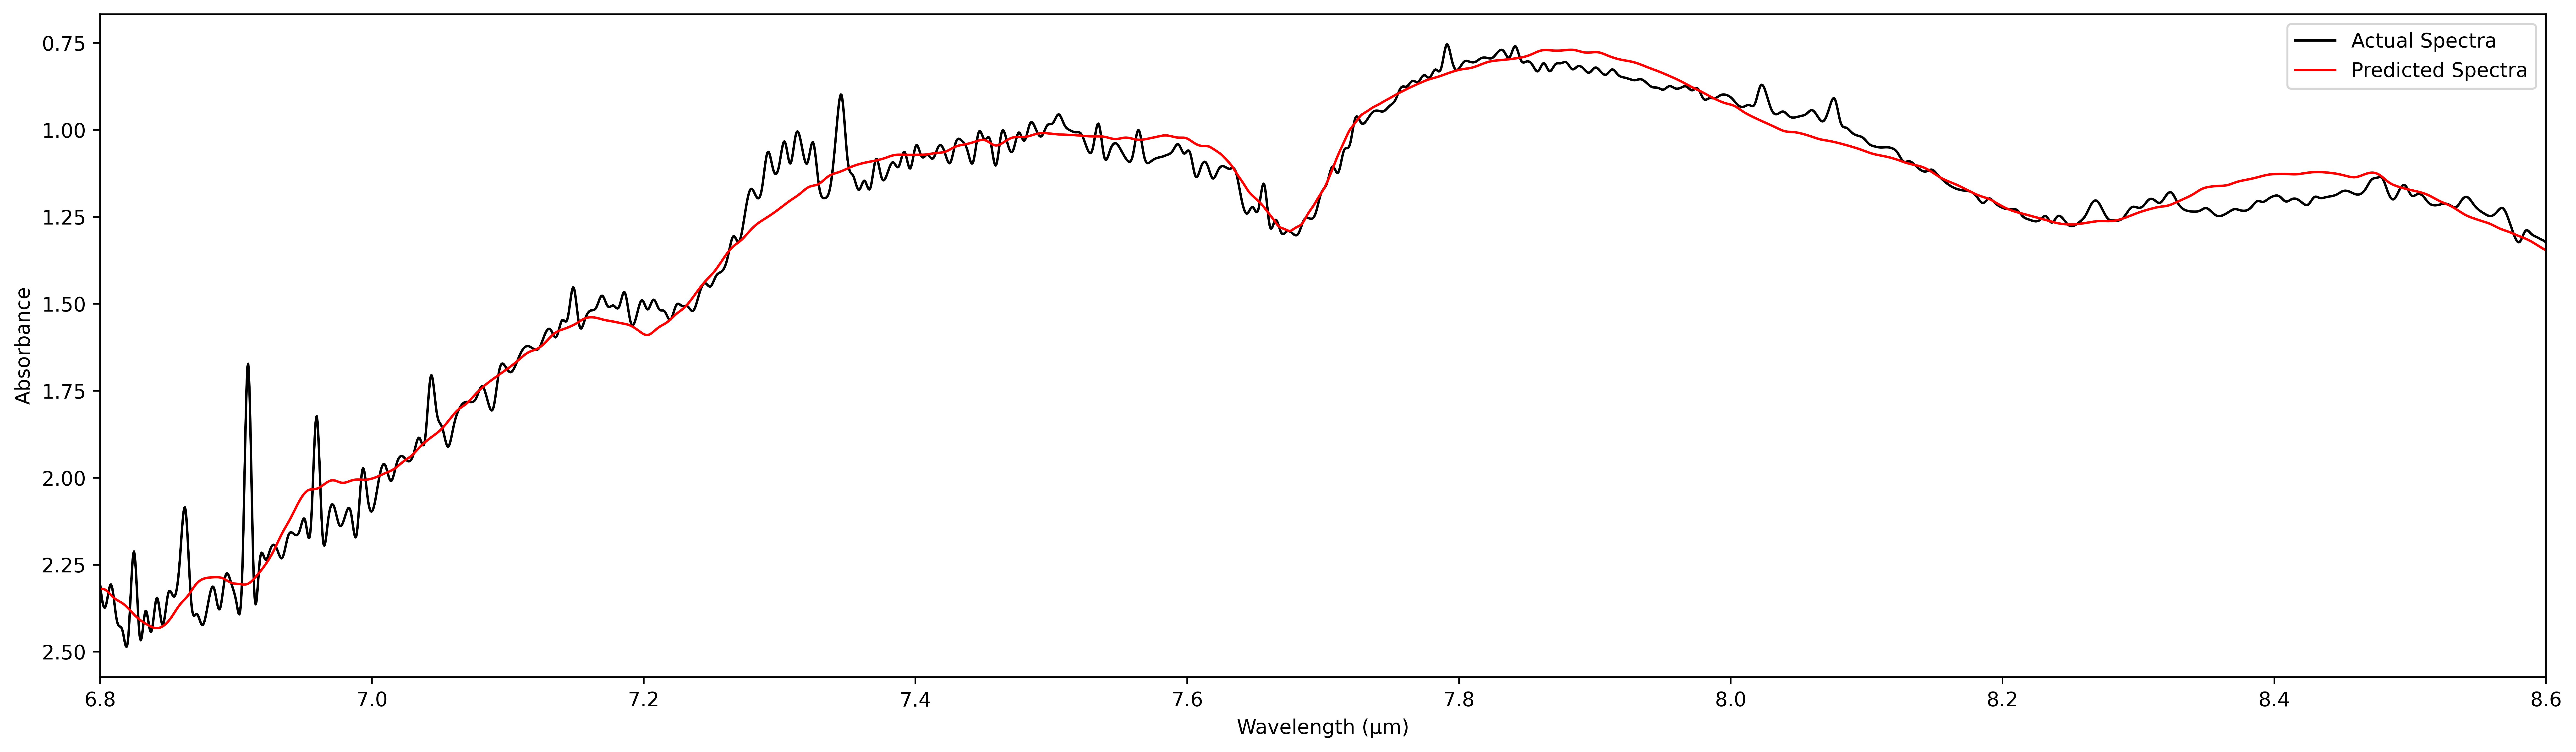

In [14]:
x_new_1=[]
keys_new_1=[]
for i in range(len(coefficients_new)):
    if coefficients_new[i]>0.5 :#and coefficients_new[i]<100:
        keys_new_1.append(keys_new[i])
        x_new_1.append(x_new[:,i])
        print(keys_new[i],": Error = ",errors_new[i],", Correlation = ",correlations_new[i],", Coefficient = ",coefficients_new[i],", Coefficient mcmc= ",accepted_samples_end[i],)

x_new_1=np.array(x_new_1)
x_new_1 = x_new_1.transpose()
absorbance_pred_new = np.zeros((len(absorbance_syn)))
mse,coefficients_new_1,errors_new_1,correlations_new_1=ml(x_new_1,y)
for i in range(x_new_1.shape[1]):
    absorbance_pred_new+=(x_new_1[:,i]*coefficients_new_1[i])


plt.figure(figsize=(22,6),dpi=600)
plt.plot(wavelength_syn,y,color="black",label="Actual Spectra",linewidth=1.2)
plt.plot(wavelength_syn,absorbance_pred_new,color="red",label="Predicted Spectra",linewidth=1.2)
plt.xlabel("Wavelength (\u03BCm)")
plt.ylabel("Absorbance")
plt.xlim(a,b)
plt.legend()
plt.gca().invert_yaxis()
plt.show()

### Printing the coefficients and correlations of the component spectras

In [15]:
for i in range(len(coefficients_new_1)):
        print(keys_new_1[i],": Error = ",errors_new_1[i],", Correlation = ",correlations_new_1[i],", Coefficient = ",coefficients_new_1[i])

H2O_CH4_10_0.6_a_V3 : Error =  0.03867236395547269 , Correlation =  0.533479021189613 , Coefficient =  8.90746935812337
H2O_HCOOH_1_1_a : Error =  0.033050910573408476 , Correlation =  0.03850078887149066 , Coefficient =  0.566789028437054
H2O_HCOOH_1_1_b : Error =  0.010954504645702912 , Correlation =  0.5563055557010105 , Coefficient =  1.92028948548742
H2O_NH3_1_0.5_c : Error =  0.024274250910600648 , Correlation =  0.8627521079001977 , Coefficient =  4.237084381273995
d_NH3_CH3OH_50_10K_I10m_Baselined : Error =  0.1648095214558336 , Correlation =  0.5843657663117604 , Coefficient =  167.20011156854133
H2O_CH3OH_CO_NH3_100K_NASA : Error =  0.021634756772639152 , Correlation =  0.9177818266586696 , Coefficient =  21.276698930888962
H2O_CO_20_1_16K : Error =  0.011991032273888758 , Correlation =  0.7403818796823078 , Coefficient =  4.484403688488012
CH3OH_120K_NASA : Error =  0.026871081915655015 , Correlation =  0.6799888736917203 , Coefficient =  0.8433362981070973
